In [1]:
import os
import shutil
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dir_list = ['boron-B',
 'calcium-Ca',
#  'healthy',
 'iron-Fe',
 'magnesium-Mg',
 'manganese-Mn',
 'more-deficiencies',
 'nitrogen-N',
 'phosphorus-P',
 'potasium-K']

for classes in dir_list:
    
    kaggle_input_dir = '/kaggle/input/coffee-leaf-disease-akash/CoLeaf DATASET/' + classes

    temp_dir = '/kaggle/working/temp/' + classes

    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    generated_images = datagen.flow_from_directory(
        kaggle_input_dir,
        save_to_dir=temp_dir,
        batch_size = 1,
        save_prefix=classes,
        save_format='jpg'
    )

    num_images = 500
    for i in range(num_images):
        generated_image = next(generated_images)


    shutil.make_archive('/kaggle/temp/' + classes, 'zip', temp_dir)



2024-05-19 12:17:05.699873: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 12:17:05.699974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 12:17:05.845568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 101 images belonging to 1 classes.
Found 162 images belonging to 1 classes.
Found 65 images belonging to 1 classes.
Found 79 images belonging to 1 classes.
Found 83 images belonging to 1 classes.
Found 104 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 246 images belonging to 1 classes.
Found 96 images belonging to 1 classes.


In [37]:
import os

for dirname, _, filenames in os.walk('/kaggle/working/temp'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import os

# Define dataset paths
dataset_path = '/kaggle/working/temp'
categories = os.listdir(dataset_path)
num_classes = len(categories)

# Load images and labels
def load_data():
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        for root, _, files in os.walk(category_path):
            for img_name in files:
                img_path = os.path.join(root, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))  # Resize images to 224x224
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Failed to load image: {img_path}")
    return np.array(images), np.array(labels)

images, labels = load_data()

# Ensure that we have loaded images
if len(images) == 0:
    raise Exception("No images loaded. Check dataset path and image files.")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

print("Data loading and preprocessing completed successfully.")


Data loading and preprocessing completed successfully.


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import VGG16
import seaborn as sns
import PIL

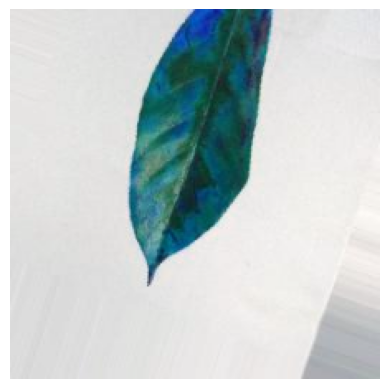

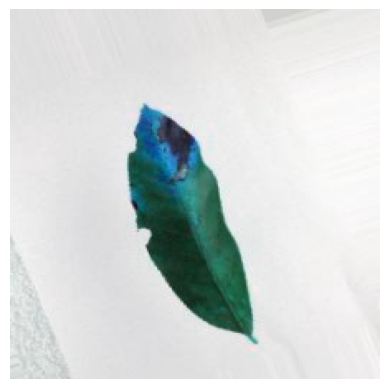

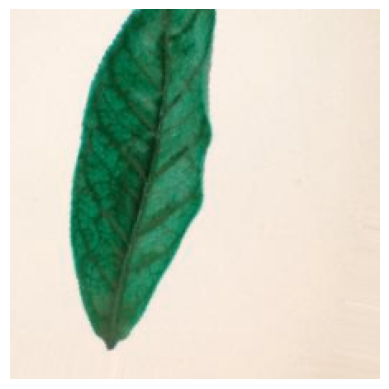

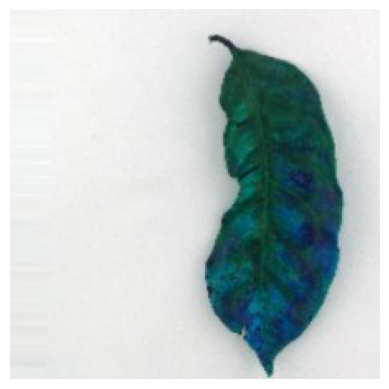

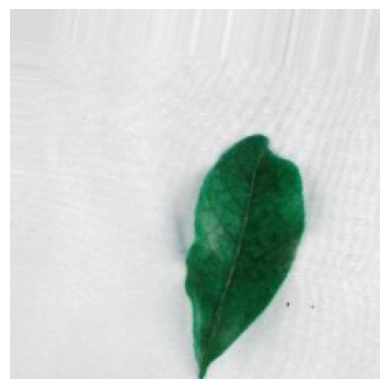

In [3]:
for i in range(5):
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Hide axis
    plt.show()

In [42]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_mobilenetv2_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenetv2_model = create_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=num_classes)

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks for MobileNetV2 model
callbacks_mobilenetv2 = [
    ModelCheckpoint('mobilenetv2_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
]

# Train MobileNetV2 model
history_mobilenetv2 = mobilenetv2_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=callbacks_mobilenetv2
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/113 ━━━━━━━━━━━━━━━━━━━━ 21:34 12s/step - accuracy: 0.1562 - loss: 2.4364

W0000 00:00:1716127710.510667     211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.3858 - loss: 1.7837

W0000 00:00:1716127754.233801     212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 420ms/step - accuracy: 0.3875 - loss: 1.7780 - val_accuracy: 0.5756 - val_loss: 1.1331
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 315ms/step - accuracy: 0.6013 - loss: 1.0805 - val_accuracy: 0.5878 - val_loss: 1.0587
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 312ms/step - accuracy: 0.6300 - loss: 0.9922 - val_accuracy: 0.6133 - val_loss: 1.0147
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 313ms/step - accuracy: 0.6645 - loss: 0.8875 - val_accuracy: 0.6689 - val_loss: 0.8998
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - accuracy: 0.7026 - loss: 0.8050 - val_accuracy: 0.7033 - val_loss: 0.7779
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 309ms/step - accuracy: 0.7243 - loss: 0.7541 - val_accuracy: 0.6833 - val_loss: 0.8577
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 307ms/step - accuracy: 0.7375 - loss: 0.7157 - val_accuracy: 0.6733 - val_loss: 0.8366
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 311ms/step - accuracy: 0.7568 - loss: 0.6583 - val

In [47]:
loss, accuracy = mobilenetv2_model.evaluate(X_val, y_val)
accuracy

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8380 - loss: 0.5064


0.8411111235618591

In [6]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def create_DenseNet121_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Regularization
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

DenseNet121_model = create_DenseNet121_model(input_shape=(224, 224, 3), num_classes=num_classes)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import math

def step_decay(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(step_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.00001)
callbacks_denseNet121_model = [
    ModelCheckpoint('densenet121_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1),
    lr_scheduler,
    reduce_lr
]


history_denseNet121 = DenseNet121_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=callbacks_denseNet121_model
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:16:08 41s/step - accuracy: 0.1250 - loss: 2.5901

I0000 00:00:1716287535.480862     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716287535.557619     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/113 ━━━━━━━━━━━━━━━━━━━━ 49s 744ms/step - accuracy: 0.2600 - loss: 2.2151

W0000 00:00:1716287568.943334     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.3203 - loss: 1.9988

W0000 00:00:1716287601.062180     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 122s 727ms/step - accuracy: 0.3209 - loss: 1.9966 - val_accuracy: 0.5211 - val_loss: 1.3117 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 327ms/step - accuracy: 0.4465 - loss: 1.5198 - val_accuracy: 0.4967 - val_loss: 1.3955 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 336ms/step - accuracy: 0.5044 - loss: 1.4012 - val_accuracy: 0.6156 - val_loss: 1.1263 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 331ms/step - accuracy: 0.4915 - loss: 1.3579 - val_accuracy: 0.5344 - val_loss: 1.2435 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 327ms/step - accuracy: 0.5039 - loss: 1.3294 - val_accuracy: 0.5867 - val_loss: 1.1361 - learning_rate: 0.0010
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - accuracy: 0.5223 - loss: 1.2861 - val_accuracy: 0.6244 - val_loss: 1.0649 - learning_rate: 0.0010
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - accuracy: 0.5601 - loss

In [8]:
loss, accuracy = DenseNet121_model.evaluate(X_val, y_val)
accuracy

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7277 - loss: 0.8397


0.7177777886390686